# Causality Discovery Toolbox PC algorithm

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict, OrderedDict
import pathlib

import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

import sys
sys.path.append("../")

from notebooklib.save import run_tsdr, save_tsdr, load_tsdr, load_tsdr_by_chaos

In [3]:
from cdt.causality.graph import PC, GES
import networkx as nx

In [4]:
from meltria.priorknowledge.priorknowledge import SockShopKnowledge

pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewares": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [5]:
DATASET_ID = "9n6mf"
datasets_fluxrank_max_cluster = load_tsdr_by_chaos(
    DATASET_ID, suffix="fluxrank_pearsonr_medoid_only_ctnrs", revert_normalized_time_series=True,
)

In [6]:
def pagerank(cg: nx.DiGraph, record):
    pr = nx.pagerank(cg.reverse(), alpha=0.85, weight="weight")
    _records = []
    for metric_name, rank in pr.items():
        _records.append(
            (DATASET_ID, record.target_app(), record.chaos_type(), record.chaos_comp(), record.chaos_case_num(), str(metric_name), record.data_df[str(metric_name)].values, rank)
        )
    return _records

In [8]:
from diagnoser.diag import prepare_init_graph, fix_edge_directions_in_causal_graph, find_connected_subgraphs
import diagnoser.metric_node as mn

record, data_df_by_metric_type = datasets_fluxrank_max_cluster[("pod-cpu-hog", "carts")][1]
dataset = pd.concat([
    data_df_by_metric_type["containers"][-1],
    data_df_by_metric_type["services"][-1],
    # data_df_by_metric_type["middlewares"][-1],
], axis=1)
print(record.chaos_case_full())
nodes = mn.MetricNodes.from_metric_names(dataset.columns.tolist())
init_g = prepare_init_graph(nodes, pk)

carts/pod-cpu-hog/4


In [9]:
pc = PC(CItest="gaussian", alpha=0.05, method_indep="corr")
# cg = GES(score="obs").create_graph_from_init_graph(dataset, init_g)
cg = pc.create_graph_from_init_graph(dataset, init_g)
# cg = pc.predict(dataset)

In [10]:
_cg = mn.relabel_graph_labels_to_node(cg)
root_contained_graphs, root_uncontained_graphs = find_connected_subgraphs(_cg, pk.get_root_metrics())
max_graph = max(root_contained_graphs, key=lambda g: len(g.nodes))
max_graph = fix_edge_directions_in_causal_graph(max_graph, pk)

In [11]:
from eval.groundtruth import check_causal_graph

ok, _ = check_causal_graph(pk=pk, G=max_graph, chaos_comp=record.chaos_comp(), chaos_type=record.chaos_type(), optional_cause=True)
ok

False

In [12]:
## similality
g = mn.relabel_graph_nodes_to_label(max_graph)
data = dataset.filter(list(g.nodes), axis=1)
front_root_metric = [m for m in data.columns.tolist() if m in pk.get_root_metrics()][0]
front_root_metric_id = data.columns.tolist().index(front_root_metric)
corr = np.corrcoef(data.values.T)
similarities_to_front = [abs(x) for x in corr[front_root_metric_id]]
rho = 0.1
for i in g.nodes:
    for j in g.nodes:
        s_i = similarities_to_front[list(g.nodes).index(i)]
        s_j = similarities_to_front[list(g.nodes).index(j)]
        # forward edge
        if g.has_edge(i, j):
            g.edges[i, j]["weight"] = abs(s_j)
        elif g.has_edge(j, i):
            g.add_edge(i, j, weight=rho * abs(s_i))

## self edge
for i in g.nodes:
    if i == front_root_metric:
        continue
    s_i: float = similarities_to_front[list(g.nodes).index(i)]
    p_i: list[float] = [g[i][j]["weight"] for j in g[i]]
    g.add_edge(i, i, weight=max(0, s_i - max(p_i)))

# teleportation_prob = (np.array(similarities_to_front) / np.sum(similarities_to_front)).tolist()
# print(teleportation_prob)

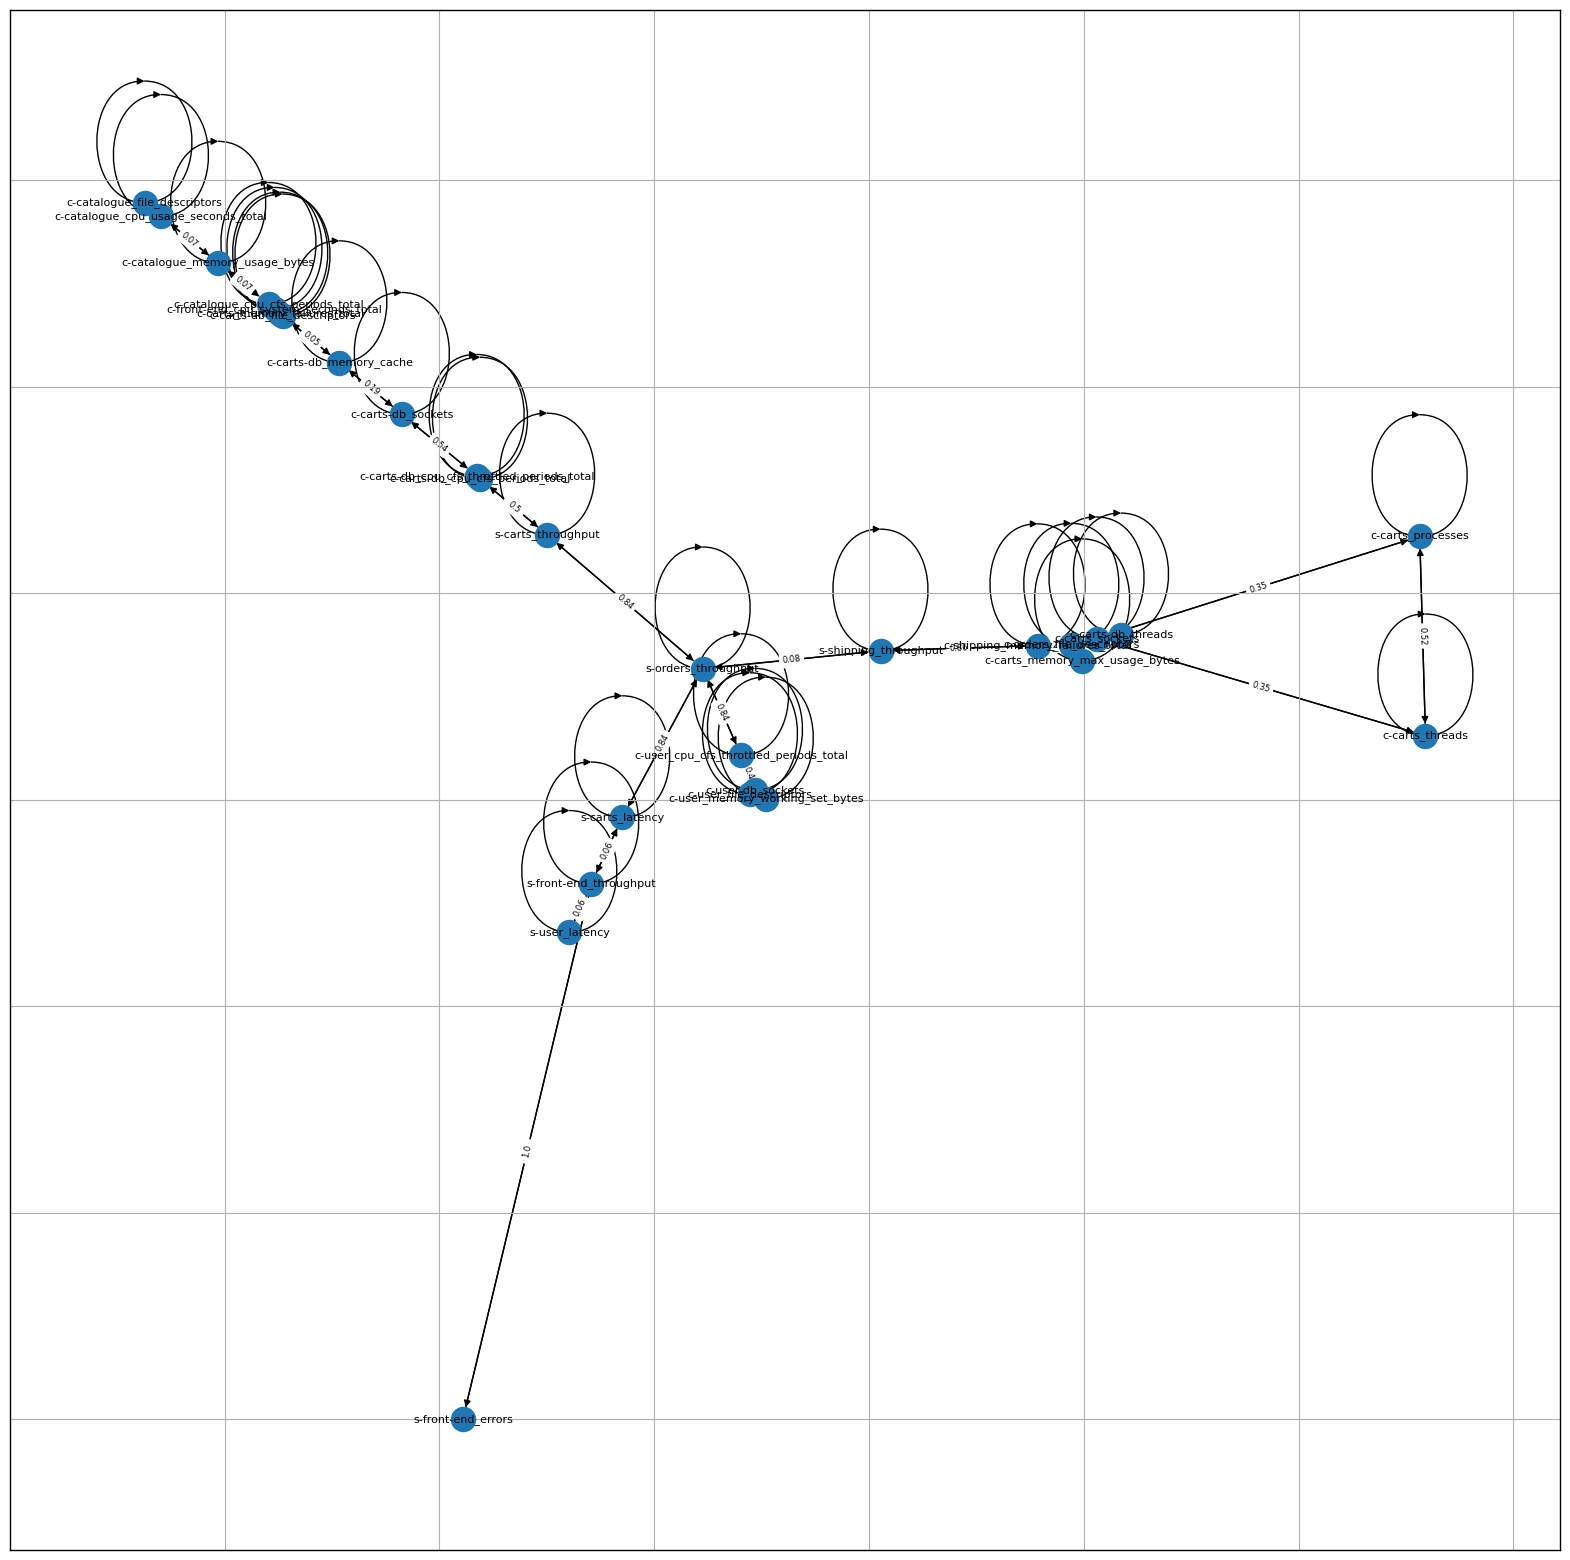

In [13]:
plt.figure(figsize=(20,20))
pos=nx.kamada_kawai_layout(g)
nx.draw_networkx(g, pos=pos, font_size=8)
# nx.set_edge_attributes(g, {(e[0], e[1]): {'label': e[2]['weight']} for e in g.edges(data=True)})
labels = {k: round(v, 2) for k, v in nx.get_edge_attributes(g, 'weight').items()}
nx.draw_networkx_edge_labels(g, pos, edge_labels=labels, font_size=6)
plt.show()

In [14]:
ranks = pagerank(g, record)
pd.DataFrame(ranks, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "chaos_case_num", "metric_name", "metric_values", "pagerank"]).sort_values("pagerank", ascending=False).head(n=15).reset_index()

,index,dataset_id,target_app,chaos_type,chaos_comp,chaos_case_num,metric_name,metric_values,pagerank
0,2,9n6mf,sock-shop,pod-cpu-hog,carts,4,c-carts_sockets,"[102.0, 104.0, 106.0, 106.0, 104.0, 104.0, 105...",0.061559
1,11,9n6mf,sock-shop,pod-cpu-hog,carts,4,c-catalogue_cpu_usage_seconds_total,"[0.0805, 0.0803, 0.0806, 0.0806, 0.0811, 0.081...",0.053923
2,20,9n6mf,sock-shop,pod-cpu-hog,carts,4,c-carts-db_memory_cache,"[60420096.0, 60420096.0, 60825600.0, 60690432....",0.053093
3,22,9n6mf,sock-shop,pod-cpu-hog,carts,4,c-user-db_sockets,"[69.0, 69.0, 72.0, 69.0, 69.0, 69.0, 69.0, 69....",0.052293
4,21,9n6mf,sock-shop,pod-cpu-hog,carts,4,c-carts-db_cpu_cfs_periods_total,"[9.9933, 7.1317, 10.0028, 9.9919, 6.85, 10.017...",0.051033
5,15,9n6mf,sock-shop,pod-cpu-hog,carts,4,s-carts_throughput,"[138.3556, 138.5778, 138.8667, 139.3778, 139.5...",0.050576
6,14,9n6mf,sock-shop,pod-cpu-hog,carts,4,c-carts_memory_max_usage_bytes,"[568684544.0, 568684544.0, 568684544.0, 568684...",0.043697
7,1,9n6mf,sock-shop,pod-cpu-hog,carts,4,c-catalogue_memory_usage_bytes,"[12509184.0, 12509184.0, 12513280.0, 12509184....",0.042963
8,25,9n6mf,sock-shop,pod-cpu-hog,carts,4,s-front-end_throughput,"[304.4889, 308.4258, 309.0444, 310.4222, 309.4...",0.042722
9,27,9n6mf,sock-shop,pod-cpu-hog,carts,4,c-carts_threads,"[143.0, 144.0, 144.0, 144.0, 145.0, 143.0, 145...",0.038614


# Refactored code

In [15]:
DATASET_ID = "9n6mf"
datasets_hdbscan_sbd = load_tsdr_by_chaos(
    DATASET_ID, suffix="hdbscan_sbd_only_ctnrs", revert_normalized_time_series=True,
)

In [101]:
from diagnoser import diag
from eval.groundtruth import check_cause_metrics

from notebooklib.plot import plot_causal_graph, plot_rank_dataframe
from notebooklib.rank import create_rank_as_dataframe

In [187]:
record, data_df_by_metric_type = datasets_hdbscan_sbd[("pod-network-latency", "user")][0]
cg, ranks = diag.build_and_walk_causal_graph(
    pd.concat([
        data_df_by_metric_type["services"][-1],
        data_df_by_metric_type["containers"][-1],
    ], axis=1),
    record.pk, 
    use_call_graph=False,
    enable_prior_knowledge=False,
    pc_library="cdt",
    cg_algo="pc",
    pc_citest="gaussian",
    pc_citest_alpha=0.05,
    pc_variant="stable",
    disable_orientation=False,
    disable_ci_edge_cut=False,
    walk_method="monitorrank",
    root_metric_type="latency",  # throughput or latency
)

In [188]:
check_cause_metrics(record.pk, list(cg.nodes), record.chaos_type(), record.chaos_comp(), optional_cause=True)

(False, )

In [189]:
rank_df = create_rank_as_dataframe(ranks, DATASET_ID, record)
rank_df

,index,dataset_id,target_app,chaos_type,chaos_comp,chaos_idx,metric_name,cause(mandatory),cause(optional),rank,metric_values
1,0,9n6mf,sock-shop,pod-network-latency,user,2,s-user_latency,False,False,0.161410,"[0.0044, 0.0044, 0.0043, 0.0044, 0.0046, 0.004..."
2,1,9n6mf,sock-shop,pod-network-latency,user,2,s-user_throughput,False,False,0.122790,"[232.8822, 232.5333, 230.4222, 227.6444, 223.7..."
3,2,9n6mf,sock-shop,pod-network-latency,user,2,s-carts_latency,False,False,0.115255,"[0.0053, 0.0054, 0.0055, 0.0056, 0.0056, 0.005..."
4,3,9n6mf,sock-shop,pod-network-latency,user,2,s-catalogue_latency,False,False,0.112264,"[0.005, 0.0051, 0.0052, 0.0058, 0.0058, 0.0057..."
5,4,9n6mf,sock-shop,pod-network-latency,user,2,c-user-db_cpu_system_seconds_total,False,False,0.101048,"[0.0338, 0.0346, 0.0344, 0.0341, 0.0328, 0.027..."
6,5,9n6mf,sock-shop,pod-network-latency,user,2,s-front-end_errors,False,False,0.090198,"[5.1778, 4.9776, 6.0222, 5.2444, 5.3113, 4.533..."
7,6,9n6mf,sock-shop,pod-network-latency,user,2,c-shipping_cpu_usage_seconds_total,False,False,0.084019,"[0.1049, 0.1119, 0.1086, 0.1023, 0.0945, 0.105..."
8,7,9n6mf,sock-shop,pod-network-latency,user,2,s-payment_latency,False,False,0.079352,"[0.0004, 0.0003, 0.0004, 0.0004, 0.0004, 0.000..."
9,8,9n6mf,sock-shop,pod-network-latency,user,2,s-shipping_latency,False,False,0.054000,"[0.0013, 0.0011, 0.0013, 0.0013, 0.0012, 0.001..."
10,9,9n6mf,sock-shop,pod-network-latency,user,2,s-orders_throughput,False,False,0.028408,"[29.3556, 29.085, 28.7556, 28.9111, 28.1149, 2..."


In [190]:
import networkx as nx
nx.info(cg)

'DiGraph with 13 nodes and 39 edges'

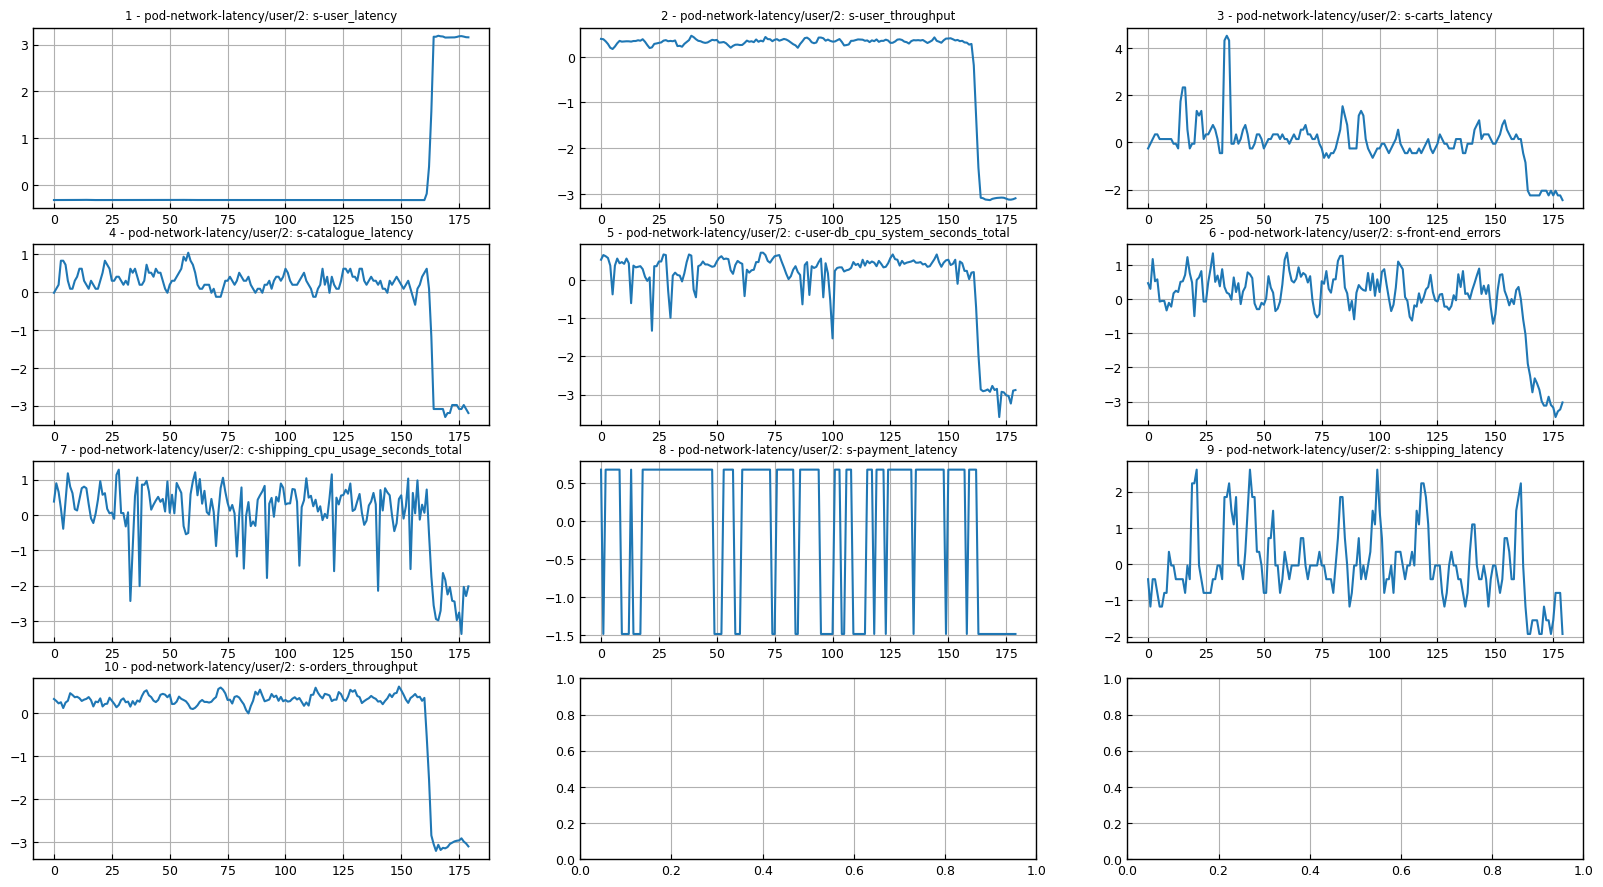

In [191]:
plot_rank_dataframe(rank_df)

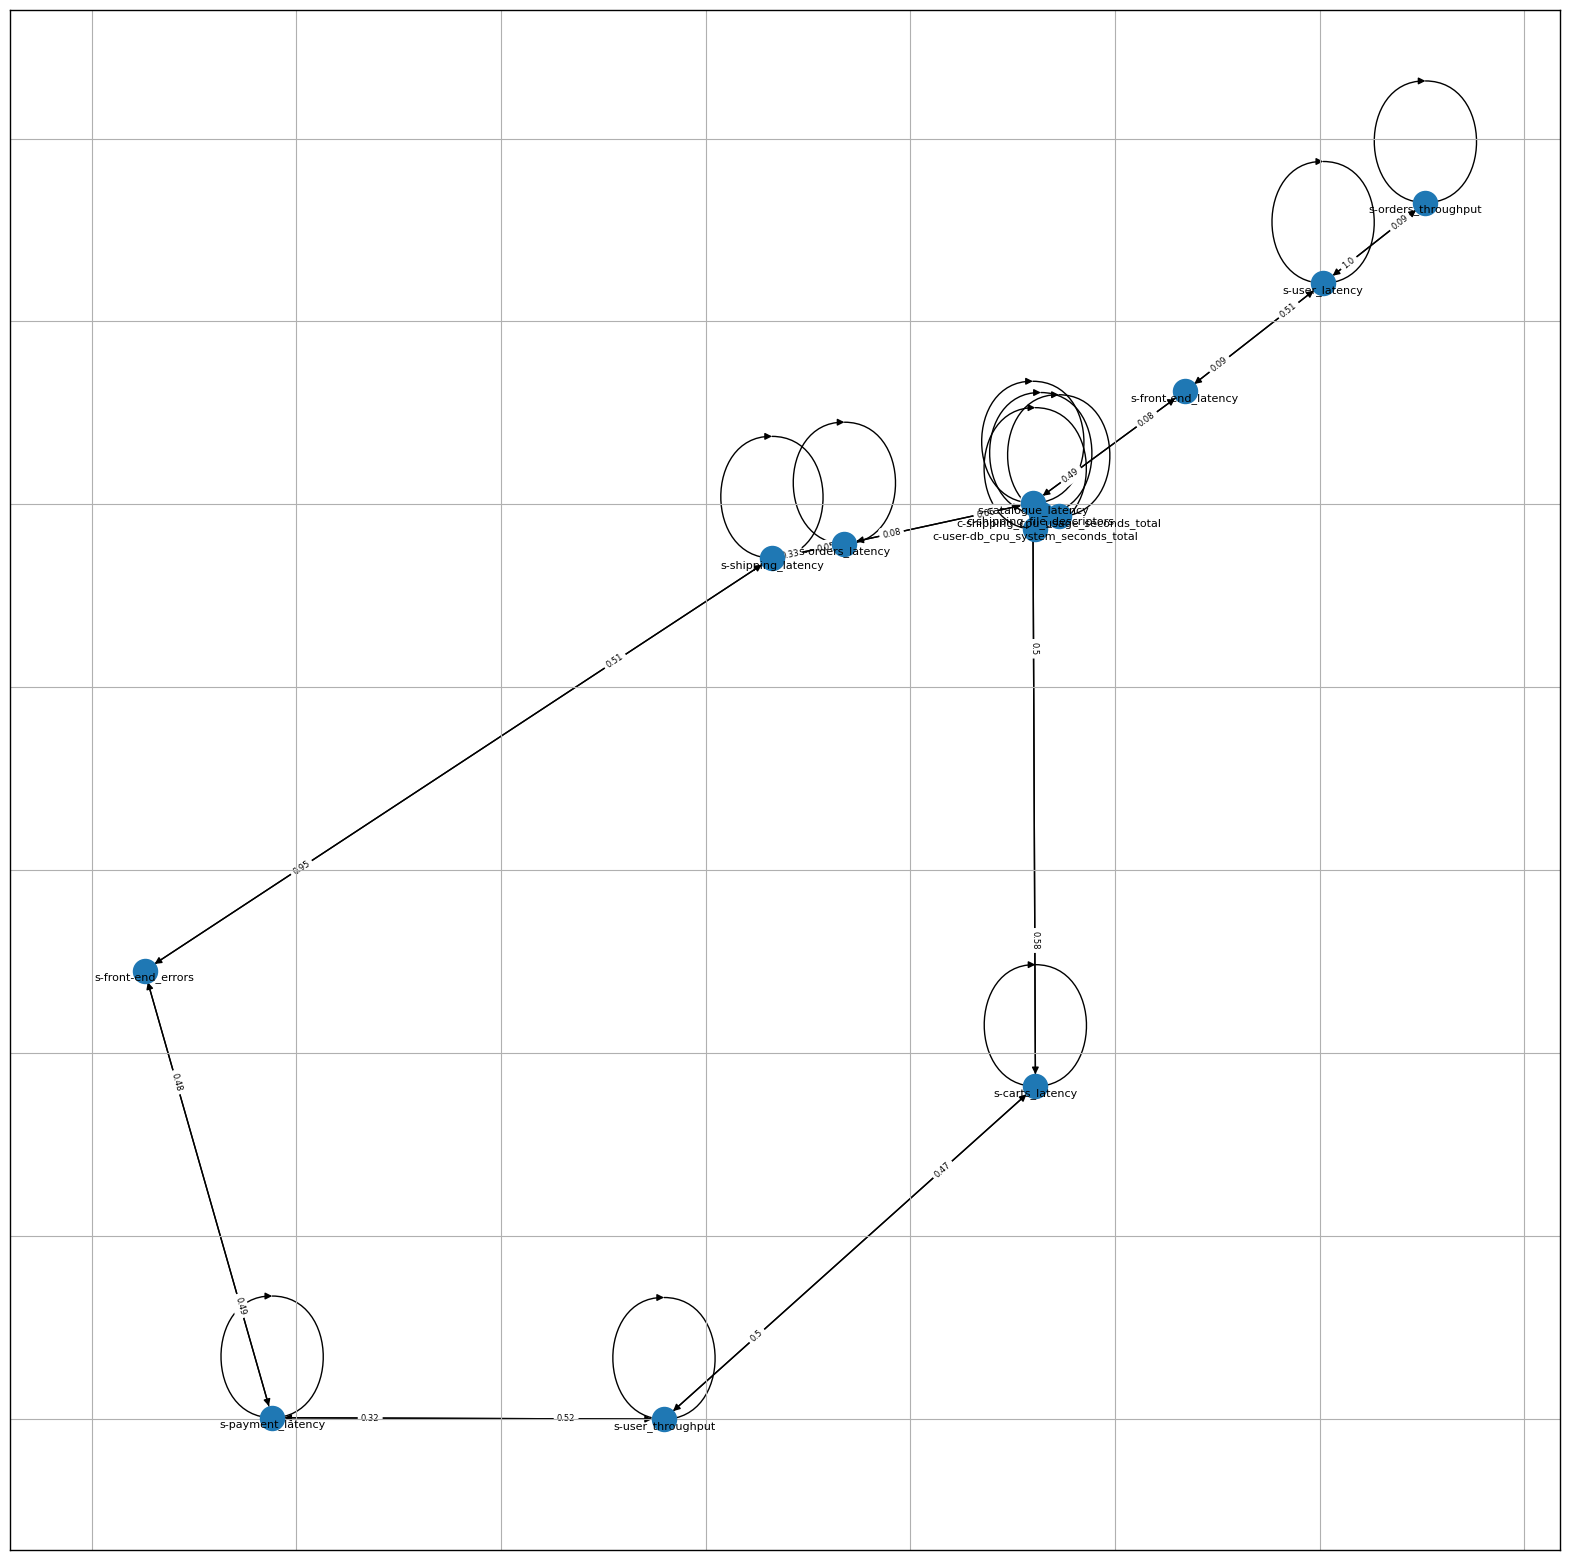

In [192]:
plot_causal_graph(cg)